In [120]:
import cv2
import numpy
from matplotlib import pyplot as plt

In [121]:
grabCut = cv2.cvtColor(cv2.imread(r"grabCut.jpg"), cv2.COLOR_BGR2RGB)
threshold = cv2.cvtColor(cv2.imread(r"threshold.jpg"), cv2.COLOR_BGR2RGB)
kmeans = cv2.cvtColor(cv2.imread(r"kmeans.jpg"), cv2.COLOR_BGR2RGB)


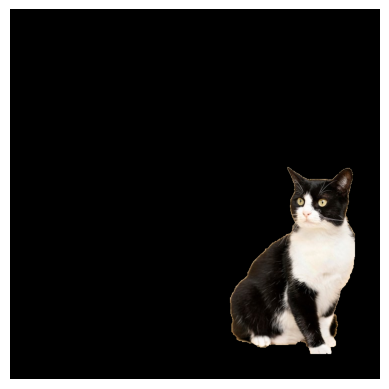

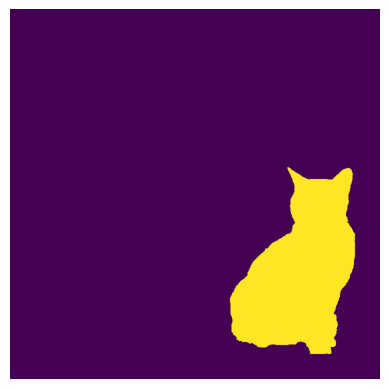

In [122]:
ptohoMask = numpy.zeros(grabCut.shape[:2], dtype="uint8")
bgdModel = numpy.zeros((1, 65), dtype="float64")
fgdModel = numpy.zeros((1, 65), dtype="float64")

rect = (50, 50, grabCut.shape[1]-100, grabCut.shape[0]-100)

cv2.grabCut(grabCut, ptohoMask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

ptohoMask2 = numpy.where((ptohoMask==2)|(ptohoMask==0), 0, 1).astype("uint8")
grabCut_nobg = grabCut * ptohoMask2[:, :, numpy.newaxis]

plt.imshow(grabCut_nobg)
plt.axis('off')
plt.show()

plt.imshow(ptohoMask2)
plt.axis('off')
plt.show()

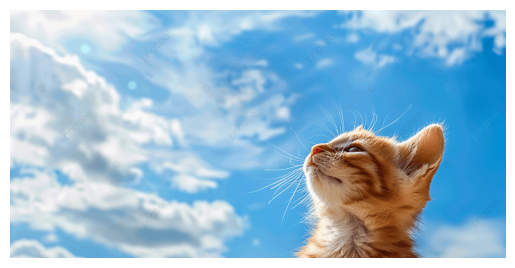

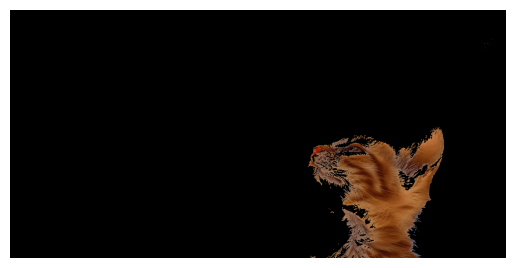

In [123]:
thresholdImage = cv2.cvtColor(threshold, cv2.COLOR_BGR2GRAY)
_, thresholdMask = cv2.threshold(thresholdImage, 120, 255, cv2.THRESH_BINARY_INV)
plt.axis("off")
plt.imshow(threshold)
plt.show()
resultThresholdImage = cv2.bitwise_and(threshold, threshold, mask=thresholdMask)
plt.axis("off")
plt.imshow(resultThresholdImage)
plt.show()


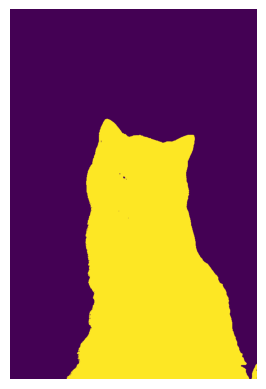

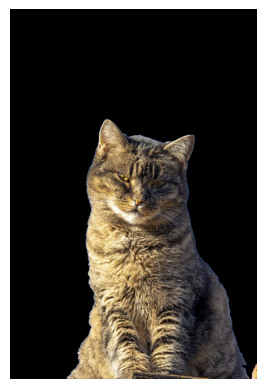

In [124]:
hsv = cv2.cvtColor(kmeans, cv2.COLOR_RGB2HSV)

# Преобразуем изображение в 2D массив пикселей
Z = hsv.reshape((-1,3))
Z = numpy.float32(Z)

# Параметры K-means
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3

# Применение K-means
ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Восстанавливаем двумерную карту меток
labels2D = label.reshape((kmeans.shape[0], kmeans.shape[1]))

# Находим самый крупный кластер (предположительно фон)
counts = numpy.bincount(label.flatten())
bg_label = numpy.argmax(counts)

# Создание маски: 0 для фона, 1 для остальных
mask1 = numpy.where(labels2D == bg_label, 0, 1).astype("uint8")

# Отображение маски
plt.imshow(mask1)
plt.axis('off')
plt.show()

# Применение маски к исходному изображению
res1 = kmeans * mask1[:, :, numpy.newaxis]
plt.imshow(res1)
plt.axis('off')
plt.show()



In [125]:
def Dice(autoMask, manualMaskPath, name):
    # загрузка ручной маски
    manualMask = cv2.imread(manualMaskPath, cv2.IMREAD_GRAYSCALE)
    if manualMask is None:
        raise ValueError("Не удалось загрузить manual mask")

    # приведение размеров
    if autoMask.shape != manualMask.shape:
        manualMask = cv2.resize(
            manualMask,
            (autoMask.shape[1], autoMask.shape[0]),
            interpolation=cv2.INTER_NEAREST
        )

    autoBin = autoMask.copy()
    if autoBin.max() <= 1.0:   # если нормализовано
        autoBin = (autoBin * 255).astype(numpy.uint8)

    # жёсткая бинаризация обеих масок
    _, autoBin = cv2.threshold(autoBin, 127, 255, cv2.THRESH_BINARY)
    _, manualBin = cv2.threshold(manualMask, 127, 255, cv2.THRESH_BINARY)

    # перевод в bool
    autoBool = autoBin > 0
    manualBool = manualBin > 0

    # Dice
    intersection = numpy.logical_and(autoBool, manualBool).sum()
    areaA = autoBool.sum()
    areaB = manualBool.sum()

    if areaA + areaB == 0:
        dice = 1.0  # обе маски пустые — полное совпадение
    else:
        dice = 2.0 * intersection / (areaA + areaB)

    # отображение
    plt.axis("off")
    plt.imshow(autoBool)
    plt.show()

    plt.axis("off")
    plt.imshow(manualBool)
    plt.show()

    print(f"Коэффициент Дайса для {name}: {dice:.14f}")
    return dice

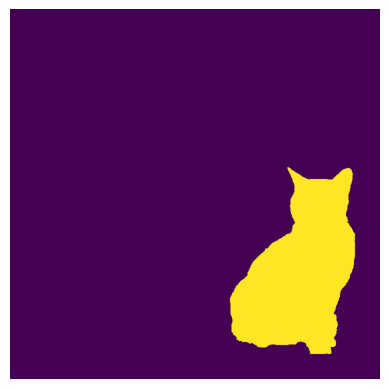

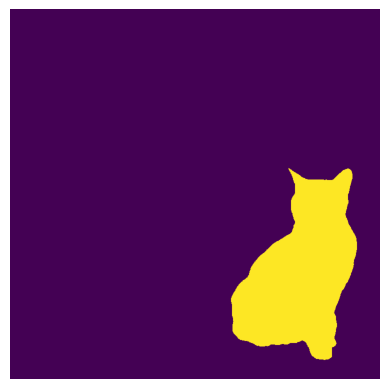

Коэффициент Дайса для GrabCut: 0.98352941176471


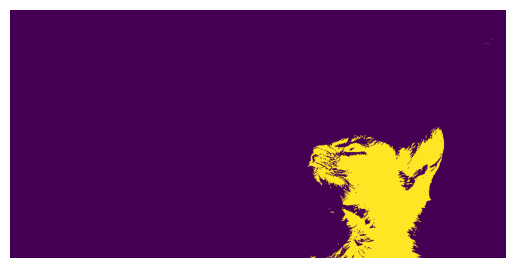

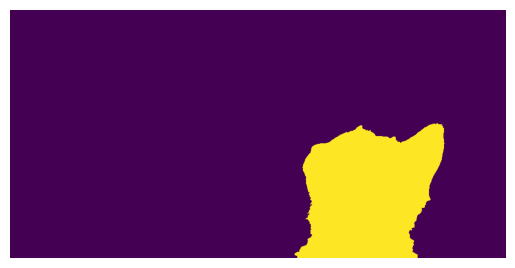

Коэффициент Дайса для Treshold: 0.78323971060742


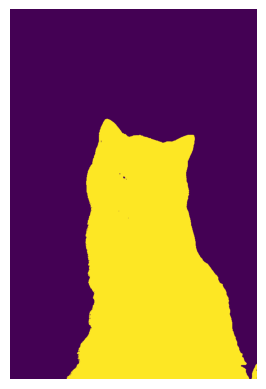

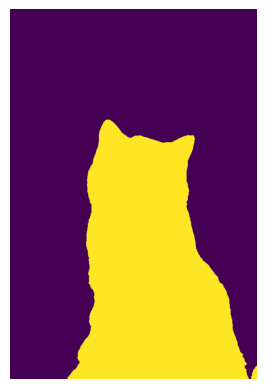

Коэффициент Дайса для K-means: 0.99564432408034


np.float64(0.9956443240803431)

In [126]:
Dice(ptohoMask2, "grabCutManual.jpg", "GrabCut")
Dice(thresholdMask, "thresholdManual.jpg", "Treshold")
Dice(mask1, "kmeansManual.jpg", "K-means")